- 데이터 불균형이 있다면 데이터 샘플링 기법을 활용할 것임
- 이번에는 무슨 관점으로 진행했는지 확실하게 짚고 넘어갈 것임
- 다양한 분석과 그 과정에서 얻은 지식을 잘 정리할 것임

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

# 폰트 설정
if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False   

import warnings
warnings.filterwarnings('ignore')

In [48]:
import random
import tensorflow as tf

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
# seed 고정
set_seed(42)  

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


df.drop(columns='ID', inplace=True)
test.drop(columns='ID', inplace=True)

df.rename(columns = {'주행거리(km)':'주행거리', '보증기간(년)':'보증기간', '연식(년)':'연식', '가격(백만원)':'가격'}, inplace=True)
test.rename(columns = {'주행거리(km)':'주행거리', '보증기간(년)':'보증기간', '연식(년)':'연식', '가격(백만원)':'가격'}, inplace=True)

df

,제조사,모델,차량상태,배터리용량,구동방식,주행거리,보증기간,사고이력,연식,가격
0,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02
...,...,...,...,...,...,...,...,...,...,...
7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95
7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40
7494,P사,TayCT,Brand New,NaN,AWD,1363,2,No,0,120.00
7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   제조사     7497 non-null   object 
 1   모델      7497 non-null   object 
 2   차량상태    7497 non-null   object 
 3   배터리용량   4786 non-null   float64
 4   구동방식    7497 non-null   object 
 5   주행거리    7497 non-null   int64  
 6   보증기간    7497 non-null   int64  
 7   사고이력    7497 non-null   object 
 8   연식      7497 non-null   int64  
 9   가격      7497 non-null   float64
dtypes: float64(2), int64(3), object(5)
memory usage: 585.8+ KB


In [4]:
df.isnull().sum()

제조사         0
모델          0
차량상태        0
배터리용량    2711
구동방식        0
주행거리        0
보증기간        0
사고이력        0
연식          0
가격          0
dtype: int64

In [5]:
test.isnull().sum()

제조사        0
모델         0
차량상태       0
배터리용량    304
구동방식       0
주행거리       0
보증기간       0
사고이력       0
연식         0
dtype: int64

# EDA
데이터를 시각화 후 이상치, 결측치를 어떻게 다룰 것인지 생각한다.

- 제조사, v사가 다른 제조사에 비해 400개의 데이터가 부족 (불균형으로 판단) -> v사가 다른 제조사에 비해 비싸거나, 수입차로 물량 확보가 어렵거나 그럴 수 있음
- 모델, 모델과 제조사를 매칭하면 제조사를 특정할 수 있을 듯
- 차량상태, 새상품이 많고 거의 새거, 중고품이 거의 동일한 빈도를 가짐, 중고라고해도 연식의 범위를 보면 새거랑 무슨 차이인지 모르겠음
- 구동 방식, AWD(4륜), FWD(전륜), RWD(후륜)
- 보증기간, 2년이 제일 많고, 7~8년이 그 다음
- 사고이력, 사고 없는 차량이 매우 많음
- 연식, 대부분 2년 이하임

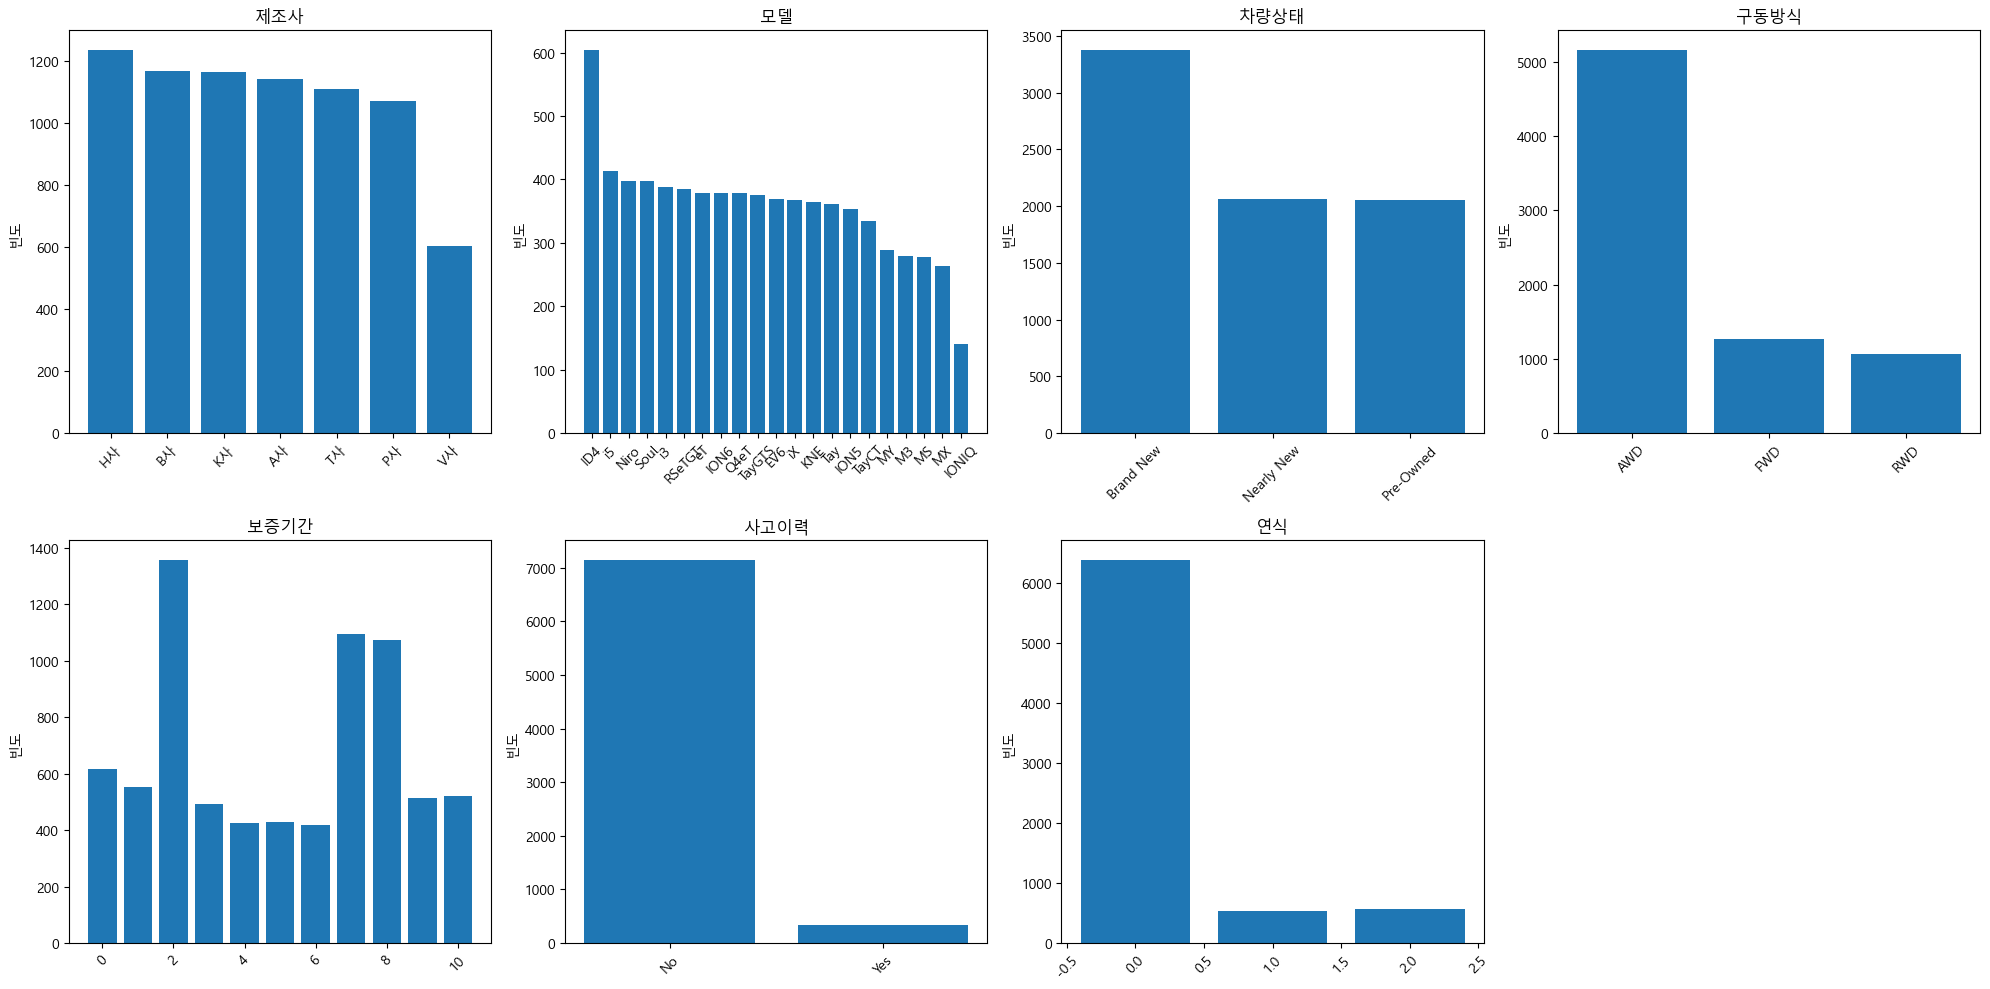

In [6]:
cols = ['제조사', '모델', '차량상태', '구동방식', '보증기간', '사고이력', '연식']

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

for i, col in enumerate(cols):
    counts = df[col].value_counts()

    axs[i].bar(counts.index, counts)
    axs[i].set_title(col)
    axs[i].set_ylabel('빈도')
    axs[i].tick_params(axis='x', rotation=45)

for j in range(len(cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

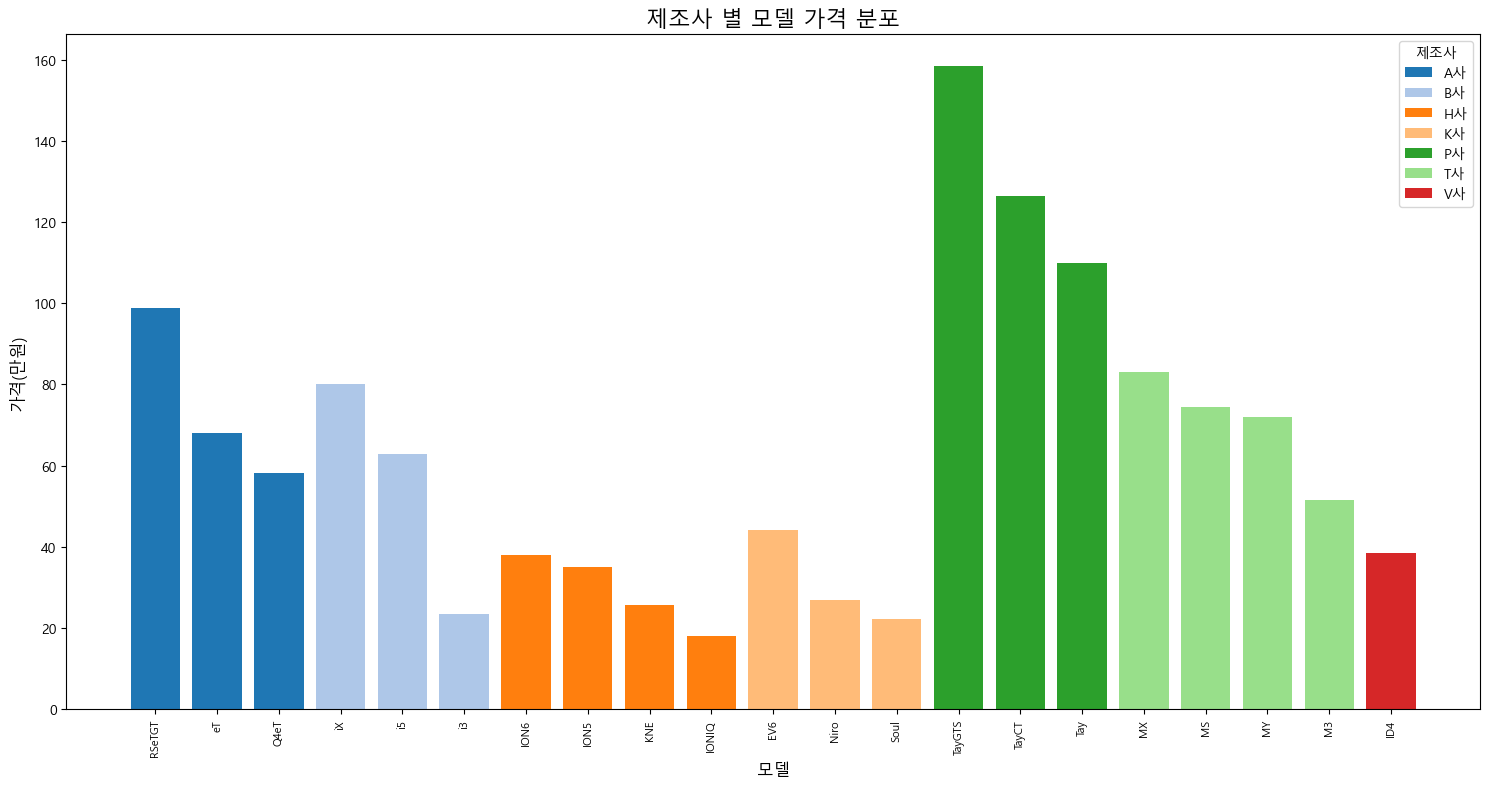

In [7]:
# 제조사의 모델별 가격의 평균으로 그룹화 합니다.
grouped_data = df.groupby(['제조사', '모델'])['가격'].mean().reset_index()

# 더 나은 그래프를 그리기 위해 제조사별로 정렬합니다.
grouped_data = grouped_data.sort_values(by=['제조사', '가격'], ascending=[True, False])

# 그래프 전체의 크기를 나타냅니다.
plt.figure(figsize=(15, 8))

# 유니크한 제조사 명을 정의합니다.
brands = grouped_data['제조사'].unique()
colors = plt.cm.tab20.colors[:len(brands)]

# 제조사별로 모델의 가격을 바 그래프 형태로 나타냅니다.
for i, brand in enumerate(brands):
    brand_data = grouped_data[grouped_data['제조사'] == brand]
    plt.bar(
        brand_data['모델'],
        brand_data['가격'],
        label=brand,
        color=colors[i % len(colors)]
    )

# 그래프의 형태를 정의합니다.
plt.title('제조사 별 모델 가격 분포', fontsize=16)
plt.xlabel('모델', fontsize=12)
plt.ylabel('가격(만원)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.legend(title='제조사', fontsize=10, loc='upper right')
plt.tight_layout()
plt.show()

### Outlier

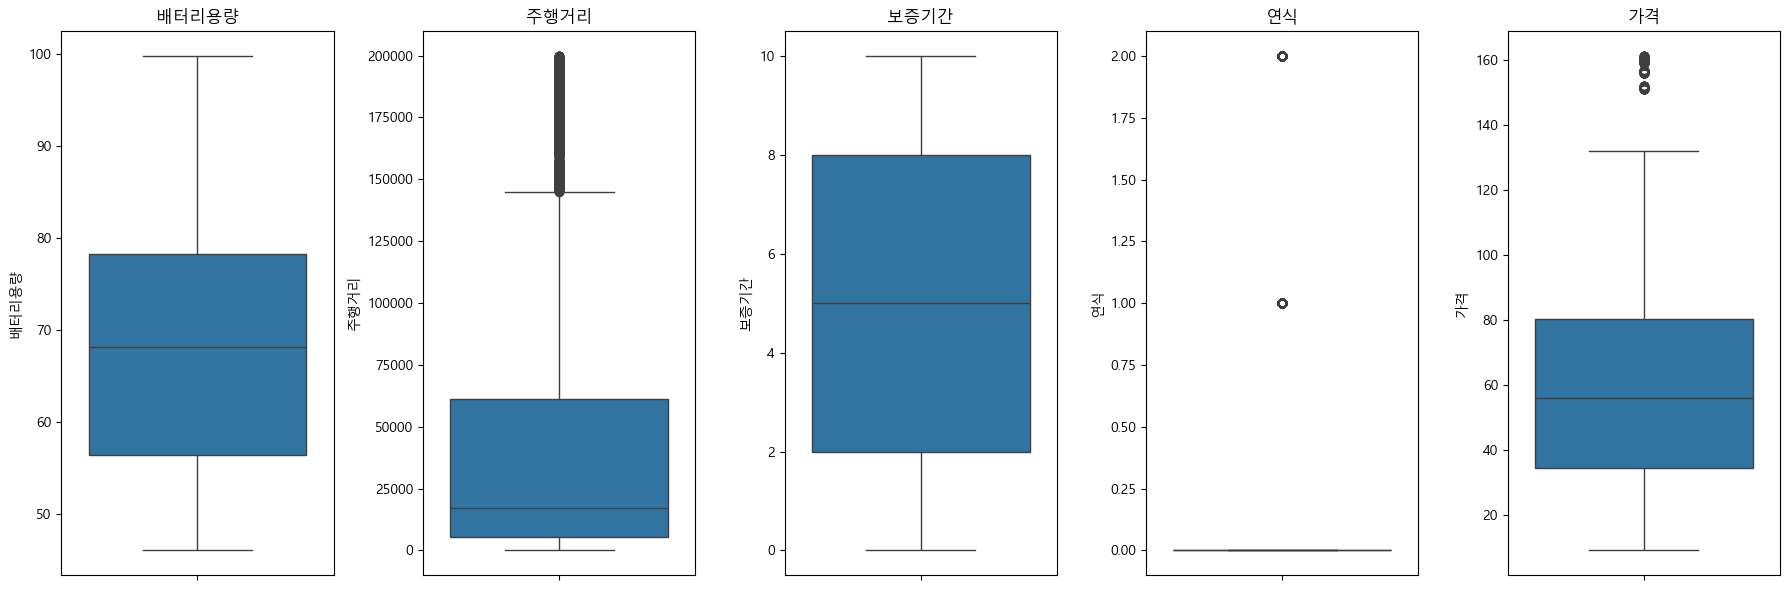

In [8]:
number = df.select_dtypes(include=np.number).columns.tolist()

fig, axs = plt.subplots(1, 5, figsize=(18, 6))

for i, col in enumerate(number):
    sns.boxplot(df[col], ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

### Missing values
- 같은 제조사 같은 모델은 배터리 용량이 동일할 것이다. -> 차량 상태(사용여부?)에 따라서 다르지만 같은 상태는 용량이 같다
- 확인하니 같은 상태라도 용량이 다른데 그 차이를 모르겠음
- 동일한 모델에서 동일한 차량 상태일 때로 결측치 대체를 하고 유니크한 값이 없는 자동차는 따로 한 번 더 확인하자.
- 모든 모델에 결측치 존재....
- 연식과 가격으로 같은 연식에서 가격오차를 0.5 ~ 1로 잡고 그 가격안에 용량으로 수정하자.

- 차량상태와 연식으로 분류하려고 했지만, 여전히 다양한 용량이 존재함 -> 가격으로 더 디테일하게 대체하자.

In [9]:
# 모델명
model_names = df.모델.unique().tolist()

# 차량상태
car_states = df.차량상태.unique().tolist()

# 연식
car_age = df.연식.unique().tolist()

for model in model_names:
    for state in car_states:
        for age in car_age:
            
            # 차량 정보 필터링
            subset = df[(df['모델'] == model) & (df['차량상태'] == state) & (df['연식'] == age)]
    
            # 배터리 용량의 유니크 값 계산
            unique_values = subset['배터리용량'].dropna().unique()
    
            if len(unique_values) == 1:
                # 유니크 값이 1개라면 결측치를 해당 값으로 대체
                value = unique_values[0]
                df.loc[(df['모델'] == model) & (df['차량상태'] == state) & (df['연식'] == age) & df['배터리용량'].isna(), '배터리용량'] = value
                test.loc[(test['모델'] == model) & (test['차량상태'] == state) & (test['연식'] == age) & test['배터리용량'].isna(), '배터리용량'] = value
                
            # 길이가 2개 이상
            elif len(unique_values) >= 2:
                # 2개 이상이라면 값이 같을 때 최빈값으로 대체 -> 가격까지 고려해서 대체하는 거로 수정. 지금은 연식으로만 최빈값 대체'
                mode_value = subset['배터리용량'].dropna().mode()[0]
                df.loc[(df['모델'] == model) & (df['차량상태'] == state) & (df['연식'] == age) & df['배터리용량'].isna(), '배터리용량'] = mode_value
                test.loc[(test['모델'] == model) & (test['차량상태'] == state) & (test['연식'] == age) & test['배터리용량'].isna(), '배터리용량'] = mode_value

In [10]:
df.isnull().sum()

제조사      0
모델       0
차량상태     0
배터리용량    0
구동방식     0
주행거리     0
보증기간     0
사고이력     0
연식       0
가격       0
dtype: int64

In [11]:
test.isnull().sum()

제조사      0
모델       0
차량상태     0
배터리용량    0
구동방식     0
주행거리     0
보증기간     0
사고이력     0
연식       0
dtype: int64

In [12]:
# missing_df = df[df['배터리용량'].isnull()]
# nomiss_df = df[~df['배터리용량'].isnull()]

# 상관관계

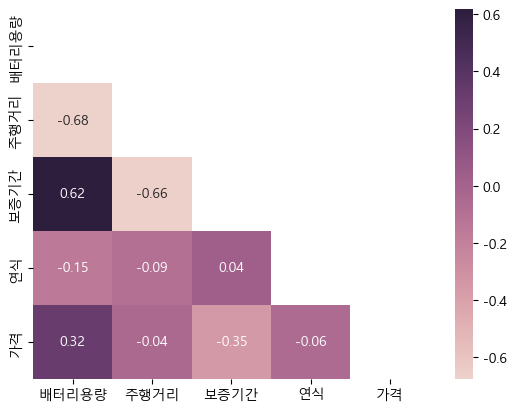

In [13]:
corrmatrix = df.select_dtypes(include=np.number).corr()
mask = np.triu(corrmatrix)
sns.heatmap(corrmatrix, annot=True, mask=mask, cmap=sns.cubehelix_palette(as_cmap=True), fmt='.2f')
plt.show()

### 가설.
- ~~제조사별 기본 가격대가 형성되어 있을 것이다.~~
- ~~같은 모델은 가격 분포가 비슷할 것이다. 다르다면 연식, 주행거리 등이 다를 것이다.~~

In [14]:
df.groupby('제조사').mean('numeric_only')

,배터리용량,주행거리,보증기간,연식,가격
제조사,,,,,
A사,81.591060,42203.521891,4.906305,0.211909,75.128354
B사,72.540869,44893.035928,4.844311,0.213003,55.212344
H사,74.139865,45106.666936,6.283751,0.299919,31.312991
K사,69.276697,43827.539519,6.743986,0.207904,30.779029
P사,80.331620,45343.483660,1.797386,0.202614,131.990934
T사,80.952878,44726.633003,4.899008,0.207394,70.153724
V사,74.767215,43592.877686,4.867769,0.193388,38.411702


하면서 느낀 것 가격을 설정하는 것은 무엇일까? 사실 모든 것이 다 가격에 유의미하다고 생각함 
왜냐 주행거리는 의미 없음

### 가설. 
가격대 분포를 통해 주행거리가 유의미한지 확인하기

In [15]:
# plt.scatter(x=train['가격'], y=train['주행거리']) 
# plt.xlabel('price')
# plt.ylabel('주행거리')
# plt.show()

In [16]:
위 상관관계를 통해서 알 수 있는 것은 가격은 주행거리, 연식에 대해서 영향력이 거의 없다.

SyntaxError: invalid syntax (309992969.py, line 1)

In [17]:
df.groupby(['제조사', '차량상태'])['가격'].mean().unstack()

차량상태,Brand New,Nearly New,Pre-Owned
제조사,,,
A사,74.552363,76.375957,74.783979
B사,69.859148,42.947315,43.352271
H사,32.759082,30.348453,30.239122
K사,37.343562,25.471514,25.301087
P사,129.021367,135.989755,133.046610
T사,65.304538,74.404207,74.464548
V사,36.707428,40.045799,39.625563


In [18]:
df.groupby('모델')['가격'].mean()

모델
EV6        44.202493
ID4        38.411702
ION5       35.070142
ION6       38.104855
IONIQ      17.991500
KNE        25.736603
M3         51.632867
MS         74.538195
MX         83.045455
MY         72.054775
Niro       26.970779
Q4eT       58.068836
RSeTGT     98.801195
Soul       22.120151
Tay       109.932188
TayCT     126.312657
TayGTS    158.298747
eT         68.095251
i3         23.561108
i5         62.873382
iX         80.032534
Name: 가격, dtype: float64

# 제조사 별 _ 브랜드 별

# Model

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

In [42]:
## 모델
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge

# 검증
from sklearn.model_selection import train_test_split, RandomizedSearchCV

## 평가 지표
from sklearn.metrics import mean_squared_error, r2_score

# 수치형 변수 스케일링
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder

rob_scaler = RobustScaler()
std_scaler = StandardScaler()

In [25]:
'''
label encoding
'''
# 범주형 변수들에 대해 label encoding 적용
categorical_columns = ['제조사', '모델', '차량상태', '구동방식', '사고이력']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    test[col] = le.transform(test[col])

In [26]:
train = df.drop(columns='가격')
target = df.가격

x_train, x_valid, y_train, y_valid = train_test_split(train, target, test_size=0.2, shuffle=True, random_state=34)

In [28]:
# linear_model = LinearRegression()
# linear_model.fit(x_train, y_train)

# y_pred = linear_model.predict(x_valid)

# mse = mean_squared_error(y_valid, y_pred)

# print(f'mse: {mse}')

mse: 393.2393639530583


In [43]:
model = XGBRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

mse = mean_squared_error(y_valid, y_pred)

print(f'mse: {mse}')

mse: 2.2412236559451153


In [44]:
model.fit(train, target)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
# 모델 및 파라미터 설정
models = {
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'CatBoost': CatBoostRegressor(silent=True),
    'XGBoost': xgb.XGBRegressor(eval_metric='rmse')
}

# 하이퍼파라미터 튜닝 설정
param_distributions = {
    'RandomForest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [None, 10, 50, 100],
        'min_samples_split': [2, 3, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1, 2, 4, 6],
    },
    'GradientBoosting': {
        'n_estimators': [100, 200, 300, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7, 20],
        'subsample': [0.8, 0.9, 1.0],
        'min_samples_split': [2, 5, 10, 15],
    },
    'CatBoost': {
        'iterations': [100, 200, 300, 500],
        'depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5, 10],
        'bagging_temperature': [0, 0.5, 1],
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
    }
}
start_time = time.time()
# 하이퍼파라미터 튜닝과 교차 검증
best_models = {}
for model_name in models:
    print(f"Tuning {model_name}...")
    search = RandomizedSearchCV(models[model_name], param_distributions[model_name],
                                 n_iter=10, cv=5, scoring='neg_mean_squared_error',  ## 
                                 random_state=42)
    search.fit(x_train, y_train)
    best_models[model_name] = search.best_estimator_
    best_score = -search.best_score_
    
    print(f"Best parameters for {model_name}: {search.best_params_}")
    print(f"Best MSE for {model_name}: {best_score:.4f}")
end_time = time.time()

print(f"실행 시간: {(end_time - start_time) / 60:.2f} 분")

Tuning RandomForest...


D:\anaconda3\envs\cqcq\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\envs\cqcq\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda3\envs\cqcq\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "D:\anaconda3\envs\cqcq\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "D:\anaconda3\envs\cqcq\lib\site-packages\sklearn\util

Best parameters for RandomForest: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}
Best MSE for RandomForest: 2.4841
Tuning GradientBoosting...
Best parameters for GradientBoosting: {'subsample': 0.9, 'n_estimators': 500, 'min_samples_split': 5, 'max_depth': 7, 'learning_rate': 0.01}
Best MSE for GradientBoosting: 2.0285
Tuning CatBoost...
Best parameters for CatBoost: {'learning_rate': 0.1, 'l2_leaf_reg': 10, 'iterations': 300, 'depth': 5, 'bagging_temperature': 0}
Best MSE for CatBoost: 2.0915
Tuning XGBoost...
Best parameters for XGBoost: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.7}
Best MSE for XGBoost: 2.0729
실행 시간: 8.22 분


In [60]:
# 모델 생성 (시드 고정)
rf_model = RandomForestRegressor(n_estimators=300, min_samples_split=4, min_samples_leaf=1, max_features='sqrt', max_depth=50, random_state=42)
gb_model = GradientBoostingRegressor(subsample=0.9, n_estimators=500, min_samples_split=5, max_depth=7, learning_rate=0.01, random_state=42)
cb_model = CatBoostRegressor(learning_rate=0.1, l2_leaf_reg=10, iterations=300, depth=5, bagging_temperature=0, verbose=0, random_seed=42)
xgb_model = XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.2, gamma=0.3, colsample_bytree=0.7, random_state=42)

In [61]:
# 모델 학습
rf_model.fit(x_train, y_train)
gb_model.fit(x_train, y_train)
cb_model.fit(x_train, y_train)
xgb_model.fit(x_train, y_train)


# RandomForestRegressor 예측
y_pred_rf = rf_model.predict(x_valid)
# GradientBoostingRegressor 예측
y_pred_gb = gb_model.predict(x_valid)
# CatBoostRegressor 예측
y_pred_cb = cb_model.predict(x_valid)
# XGBRegressor 예측
y_pred_xgb = xgb_model.predict(x_valid)


# 성능 평가
mse_rf = mean_squared_error(y_valid, y_pred_rf)
mse_gb = mean_squared_error(y_valid, y_pred_gb)
mse_cb = mean_squared_error(y_valid, y_pred_cb)
mse_xgb = mean_squared_error(y_valid, y_pred_xgb)


rmse_rf = np.sqrt(mse_rf)
rmse_gb = np.sqrt(mse_gb)
rmse_cb = np.sqrt(mse_cb)
rmse_xgb = np.sqrt(mse_xgb)
# r2 = r2_score(y_valid, np.abs(y_pred_vot))

print("-------- model score ---------")
print(f"Random MSE: {mse_rf:.4f}")
print(f'Random RMSE: {rmse_rf}')

print(f"Gradient MSE: {mse_gb:.4f}")
print(f'Gradient RMSE: {rmse_gb}')

print(f"CatBoost MSE: {mse_cb:.4f}")
print(f'CatBoost RMSE: {rmse_cb}')

print(f"XGB MSE: {mse_xgb:.4f}")
print(f'XGB RMSE: {rmse_xgb}')

# print(f"R² Score: {r2:.4f}")

-------- model score ---------
Random MSE: 2.4027
Random RMSE: 1.5500771091943697
Gradient MSE: 2.0730
Gradient RMSE: 1.4397834994609016
CatBoost MSE: 1.8377
CatBoost RMSE: 1.355603961929556
XGB MSE: 1.8457
XGB RMSE: 1.3585777860828538


In [ ]:
# 모델 학습
yeouido_voting_regressor.fit(x_train, y_train)

# 예측
y_pred_vot = yeouido_voting_regressor.predict(x_valid)

# 성능 평가
mse = mean_squared_error(y_valid, np.abs(y_pred_vot))
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, np.abs(y_pred_vot))

print("-------- voting model ---------")
print(f"MSE: {mse:.4f}")
print(f'Ensemble RMSE: {rmse}')
print(f"R² Score: {r2:.4f}")

In [ ]:
# # 제조사 분포
# counts = train['제조사'].value_counts()

# # v사가 다른 제조사에 비해 400개의 데이터가 부족 (불균형으로 판단)
# plt.bar(counts.index, counts)
# plt.xlabel('제조사')
# plt.ylabel('빈도')
# plt.show()

# Submission

In [62]:
submit = pd.read_csv('sample_submission.csv')
submit

,ID,가격(백만원)
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0
...,...,...
841,TEST_841,0
842,TEST_842,0
843,TEST_843,0
844,TEST_844,0


In [63]:
# 모델 학습
rf_model.fit(train, target)
gb_model.fit(train, target)
cb_model.fit(train, target)
xgb_model.fit(train, target)


# RandomForestRegressor 예측
y_pred_rf = rf_model.predict(test)
# GradientBoostingRegressor 예측
y_pred_gb = gb_model.predict(test)
# CatBoostRegressor 예측
y_pred_cb = cb_model.predict(test)
# XGBRegressor 예측
y_pred_xgb = xgb_model.predict(test)

In [73]:
submit['가격(백만원)'] = y_pred_xgb
submit

,ID,가격(백만원)
0,TEST_000,130.503815
1,TEST_001,80.281219
2,TEST_002,65.360016
3,TEST_003,34.944756
4,TEST_004,47.704586
...,...,...
841,TEST_841,151.362991
842,TEST_842,38.808071
843,TEST_843,38.794884
844,TEST_844,58.761707


In [74]:
# submit.to_csv('./submit/submit_6.csv',index=False)

In [76]:
df.가격.describe()

count    7497.000000
mean       62.331949
std        36.646759
min         9.000000
25%        34.390000
50%        56.000000
75%        80.050000
max       161.090000
Name: 가격, dtype: float64

In [77]:
submit['가격(백만원)'].describe()

count    846.000000
mean      62.324394
std       36.644978
min       13.840738
25%       34.184792
50%       55.920546
75%       79.982529
max      161.226028
Name: 가격(백만원), dtype: float64